In [2]:
using Knet, CUDA, MLDatasets, ArgParse, Images, Random, Statistics,Base
a_type = KnetArray{Float32}

KnetArray{Float32, N} where N

In [3]:
xtrn,ytrn = MNIST.traindata(Float32)
xtst,ytst = MNIST.testdata(Float32)
println.(summary.((xtrn,ytrn,xtst,ytst)));

28×28×60000 Array{Float32, 3}
60000-element Vector{Int64}
28×28×10000 Array{Float32, 3}
10000-element Vector{Int64}


In [4]:
batch_size = 64
dtrn = minibatch(xtrn, batch_size; xsize = (28, 28, 1,:), xtype = a_type)
dtst = minibatch(xtst, batch_size; xsize = (28, 28, 1,:), xtype = a_type);

In [5]:
struct Chain
    layers
    Chain(layers...) = new(layers)
end

(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)

struct Conv; w; b; f; p; stride; padding; end

Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0, padding = 0, stride = 1) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop, padding, stride)

(c::Conv)(x) = c.f.((conv4(c.w, dropout(x,c.p), padding = c.padding, stride = c.stride) .+ c.b))

struct DeConv; w; b; f; p; stride; padding; end

DeConv(w1::Int, w2::Int, cx::Int, cy::Int, f = relu; pdrop = 0, stride = 1, padding = 0) =
DeConv(param(w1,w2,cy,cx), param0(1,1,cy,1), f, pdrop, stride, padding)

(dc::DeConv)(x) = dc.f.(deconv4(dc.w, dropout(x, dc.p), padding = dc.padding, stride = dc.stride, mode = 1) .+ dc.b)


Encoder = Chain(Conv(3,3, 1, 16, padding = 1),
               Conv(3, 3, 16, 16 * 2, padding = 1),
               Conv(3,3,16*2, 16 * 3, padding = 1),
               Conv(3,3,16*3, 16 * 4, padding = 1)

)

Decoder = Chain(DeConv(3,3,16*4, 16*3, padding = 1),
                DeConv(3,3,16*3, 16*2, padding = 1), 
                DeConv(3,3, 16*2, 16, padding = 1), 
                DeConv(3,3, 16, 1 , padding = 1), 

)


struct Model; E::Chain; D::Chain; end
Model(Encoder, Decoder) = Model(Encoder, Decoder)
(M:: Model)(x) = M.D(M.E(x))


loss(m::Model,x,y) = mean((m(x) - y).^2)

loss (generic function with 1 method)

In [6]:
x = first(dtrn)
summary(Decoder(Encoder(x)))

"28×28×1×64 KnetArray{Float32, 4}"

In [7]:
model = Model(Encoder, Decoder)
summary(model(x))

"28×28×1×64 KnetArray{Float32, 4}"

In [8]:
number_of_epochs = 10

for epoch in 1:number_of_epochs
   for  (i,x)  in enumerate(dtrn)
        x_noisy = x + a_type(randn(Float32,size(x))*(0.5))
        x_out = model(x_noisy)
        derivative = @diff loss(model,x_noisy,x)
        
        for p in params(model)
             dp = grad(derivative, p)
             update!(value(p), dp, Knet.SGD(lr = 1e-3))
        end
        
        if (i-1) % 100 == 0
            l = value(derivative)
             println("Step $i, Loss $l")
        end
    end
end

Step 1, Loss 0.107809395
Step 101, Loss 0.11202446
Step 201, Loss 0.083437376
Step 301, Loss 0.11414623
Step 401, Loss 0.0928102
Step 501, Loss 0.0952646
Step 601, Loss 0.08429549
Step 701, Loss 0.07976066
Step 801, Loss 0.098445006
Step 901, Loss 0.081270665
Step 1, Loss 0.08241616
Step 101, Loss 0.08719989
Step 201, Loss 0.071743466
Step 301, Loss 0.092095256
Step 401, Loss 0.07735377
Step 501, Loss 0.07662844
Step 601, Loss 0.067297585
Step 701, Loss 0.06234138
Step 801, Loss 0.06685944
Step 901, Loss 0.056375843
Step 1, Loss 0.05477508
Step 101, Loss 0.052550245
Step 201, Loss 0.04415872
Step 301, Loss 0.046500895
Step 401, Loss 0.040849842
Step 501, Loss 0.03751015
Step 601, Loss 0.035872016
Step 701, Loss 0.033860732
Step 801, Loss 0.03198246
Step 901, Loss 0.03252852
Step 1, Loss 0.030460358
Step 101, Loss 0.03096015
Step 201, Loss 0.029263204
Step 301, Loss 0.031042714
Step 401, Loss 0.029248899
Step 501, Loss 0.028361283
Step 601, Loss 0.028608786
Step 701, Loss 0.028704511
St

In [9]:
mse_loss = 0
last_i = 0
for  (i,x)  in enumerate(dtst)
        x_noisy = x + a_type(randn(Float32,size(x))*(0.5))
        x_out = model(x_noisy)
        mse_loss += loss(model,x_noisy,x)
        last_i = i
end

In [10]:
 PNSR = 10 *log10(1/(mse_loss/last_i))

17.192572f0

In [11]:
using Plots

In [12]:
x = first(dtrn)
x_noisy = x + a_type(randn(Float32,size(x))*(0.5));
x_rec =  model(x_noisy);

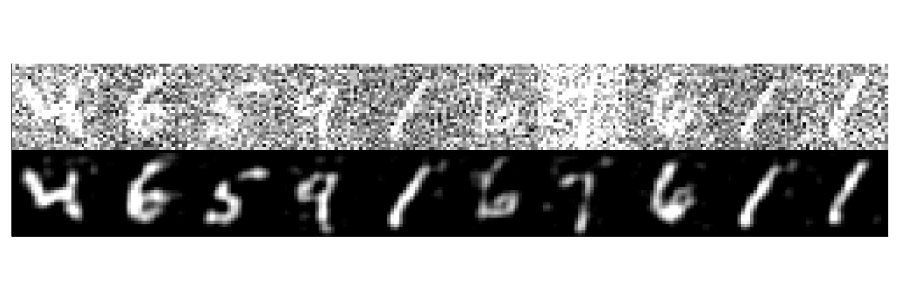

In [13]:
function plot_reconstructed_images(im_ori, im_rec, n_instances = 10, max_instance = 64)
    k = rand(1:max_instance, n_instances)
    vv = reshape(im_ori[:,:,:,k[1]], (28, 28))'
    ori_plot_list = (vv.-minimum(vv))./maximum(vv)
    recon_plot_list = reshape(im_rec[:,:,:,k[1]], (28, 28))'
    for j in k[2:end]
        vv = reshape(im_ori[:,:,:,j], (28, 28))'
        ori_plot_list = hcat(ori_plot_list, (vv.-minimum(vv))./maximum(vv))
        recon_plot_list = hcat(recon_plot_list, reshape(im_rec[:,:,:,j], (28, 28))')
    end
    p1 = plot(Matrix{Gray{Float32}}(vcat(ori_plot_list,recon_plot_list)), size = (40,400),xtick = false, ytick = false)
    plot(p1, size = (900,300))
end

plot_reconstructed_images(x_noisy,x_rec)